In [51]:
# General Utilities
import os
import random
import warnings
from pathlib import Path

# Numerical and Data Processing
import numpy as np
import pandas as pd
from scipy import stats

# Network Analysis
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from select import error
from sklearn.metrics import normalized_mutual_info_score
import networkx_temporal as tx
import networkx as nx
import leidenalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerBase
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import matplotlib.lines as mlines

# Geospatial Data
import geopandas as gpd

# Country Information
import pycountry

# String Matching
from fuzzywuzzy import process

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### 1) Load and Preprocess Data

In [52]:
# Load and preprocess dataset
hs_code = 282520 # only required to instantiate loader, not doing anything
hs_label = "Total"

# Create dir for exporting plots
export_path = os.path.join("figures", hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 27.2835 seconds


In [53]:
# Returns efficiently handled polar dataframe
df = loader.get_data()

In [54]:
# Extracts the distinct years
years = sorted(df['t'].unique())

In [55]:
baseline_df = loader.get_baseline(load_precompute=True)

In [56]:
yearly_graphs = loader.get_yearly_graphs(years)

In [57]:
# Loads Base Data
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

In [58]:
# TO REPLACE LITHIUM WITH TOTAL
df = baseline_df
yearly_graphs = yearly_baseline_graph

In [59]:
df

,t,import_country,export_country,v
0,2001,Afghanistan,Australia,319.378
1,2001,Afghanistan,Austria,142.477
2,2001,Afghanistan,Azerbaijan,190.776
3,2001,Afghanistan,Bahrain,4.266
4,2001,Afghanistan,Bangladesh,6008.931
...,...,...,...,...
672029,2022,Zimbabwe,United Kingdom,85564.157
672030,2022,Zimbabwe,United Republic of Tanzania,15260.089
672031,2022,Zimbabwe,Uruguay,220.626
672032,2022,Zimbabwe,Vietnam,251.952


In [60]:
baseline_df

,t,import_country,export_country,v
0,2001,Afghanistan,Australia,319.378
1,2001,Afghanistan,Austria,142.477
2,2001,Afghanistan,Azerbaijan,190.776
3,2001,Afghanistan,Bahrain,4.266
4,2001,Afghanistan,Bangladesh,6008.931
...,...,...,...,...
672029,2022,Zimbabwe,United Kingdom,85564.157
672030,2022,Zimbabwe,United Republic of Tanzania,15260.089
672031,2022,Zimbabwe,Uruguay,220.626
672032,2022,Zimbabwe,Vietnam,251.952


### 2) Material Specific Trade Overview

In [61]:
class HandlerLineImage(HandlerBase):
    def __init__(self, path, space=10, offset=0):
        self.space = space
        self.offset = offset
        self.image_data = plt.imread(path)
        super().__init__()

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        line = mlines.Line2D([xdescent + self.offset, xdescent + (width - self.space) / 3. + self.offset],
                             [ydescent + height / 2., ydescent + height / 2.],
                             color=orig_handle.get_color(),
                             lw=orig_handle.get_linewidth(),
                             linestyle=orig_handle.get_linestyle())
        line.set_clip_on(False)
        line.set_transform(trans)

        bbox = Bbox.from_bounds(xdescent + (width + self.space) / 3. + self.offset,
                                ydescent,
                                height * self.image_data.shape[1] / self.image_data.shape[0],
                                height)
        t_bbox = TransformedBbox(bbox, trans)
        image = BboxImage(t_bbox)
        image.set_data(self.image_data)
        self.update_prop(image, orig_handle, legend)

        return [line, image]


def get_flag_path(country_code: str) -> str:
    return os.path.join("data", "dataset", "png100px", f"{country_code.lower()}.png")


def add_flag_to_chart(ax, x, y, country_code, zoom=0.15):
    flag_path = get_flag_path(country_code)
    try:
        img = plt.imread(flag_path)
        im = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except FileNotFoundError:
        print(f"Flag image not found for {country_code} and path {flag_path}")


def create_bump_chart_with_flags(df, category, top_n, value_col="v", time_col="t", figsize=(14, 6), palette="tab20"):
    df_grouped = (
        df.groupby([time_col, category])[value_col]
        .sum()
        .reset_index()
        .sort_values(by=[time_col, value_col], ascending=[True, False])
    )

    df_grouped['rank'] = (
        df_grouped.groupby(time_col)[value_col]
        .rank(method='first', ascending=False)
        .astype(int)
    )

    df_top = df_grouped[df_grouped['rank'] <= top_n]
    df_pivot = df_top.pivot(index=category, columns=time_col, values='rank')
    df_pivot = df_pivot.loc[df_pivot.min(axis=1).sort_values().index]
    fig, ax = plt.subplots(figsize=figsize)
    colors = sns.color_palette(palette, len(df_pivot))

    legend_handlers = {}
    for idx, (row, color) in enumerate(zip(df_pivot.iterrows(), colors)):

        category_name = row[0]
        country_code = loader.get_country_code(category_name)

        line, = ax.plot(
            df_pivot.columns, row[1], label=category_name,
            lw=3.5, markersize=0, alpha=0.85, color=color, zorder=1
        )
        for x, y in zip(df_pivot.columns, row[1]):
            if country_code:
                add_flag_to_chart(ax, x, y, country_code, zoom=0.15)
        if country_code:
            flag_path = get_flag_path(country_code)
            legend_handlers[line] = HandlerLineImage(flag_path)
    ax.invert_yaxis()
    ax.set_xticks(df_pivot.columns)
    ax.set_yticks(range(1, top_n + 1))
    ax.set_xticklabels(df_pivot.columns, fontsize=12, rotation=45)
    ax.set_yticklabels(range(1, top_n + 1), fontsize=12)
    ax.set_title(f"Top {top_n} {category.split('_')[0].title()}ers", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("Year", fontsize=14, labelpad=15)
    ax.set_ylabel("Rank", fontsize=14, labelpad=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    legend = ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.5),
        title=" ".join(category.split("_")).title(),
        fontsize=10,
        title_fontsize=12,
        handler_map=legend_handlers,
        ncol=8
    )
    plt.subplots_adjust(bottom=0.5)
    plt.tight_layout()
    output_file = os.path.join(export_path, f"{hs_label}_bump_chart_{category}_{top_n}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight', bbox_extra_artists=[legend])
    plt.show()


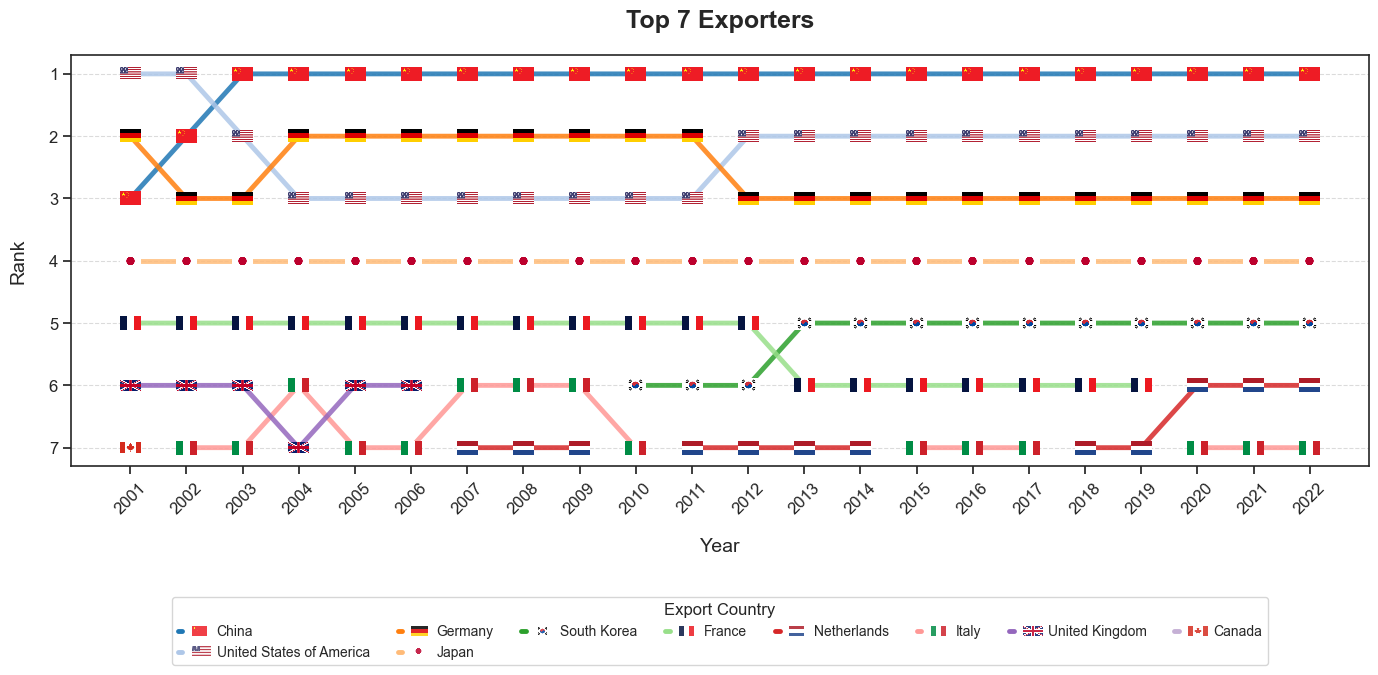

In [62]:
create_bump_chart_with_flags(
    df=df,
    category='export_country',
    top_n=7,
)

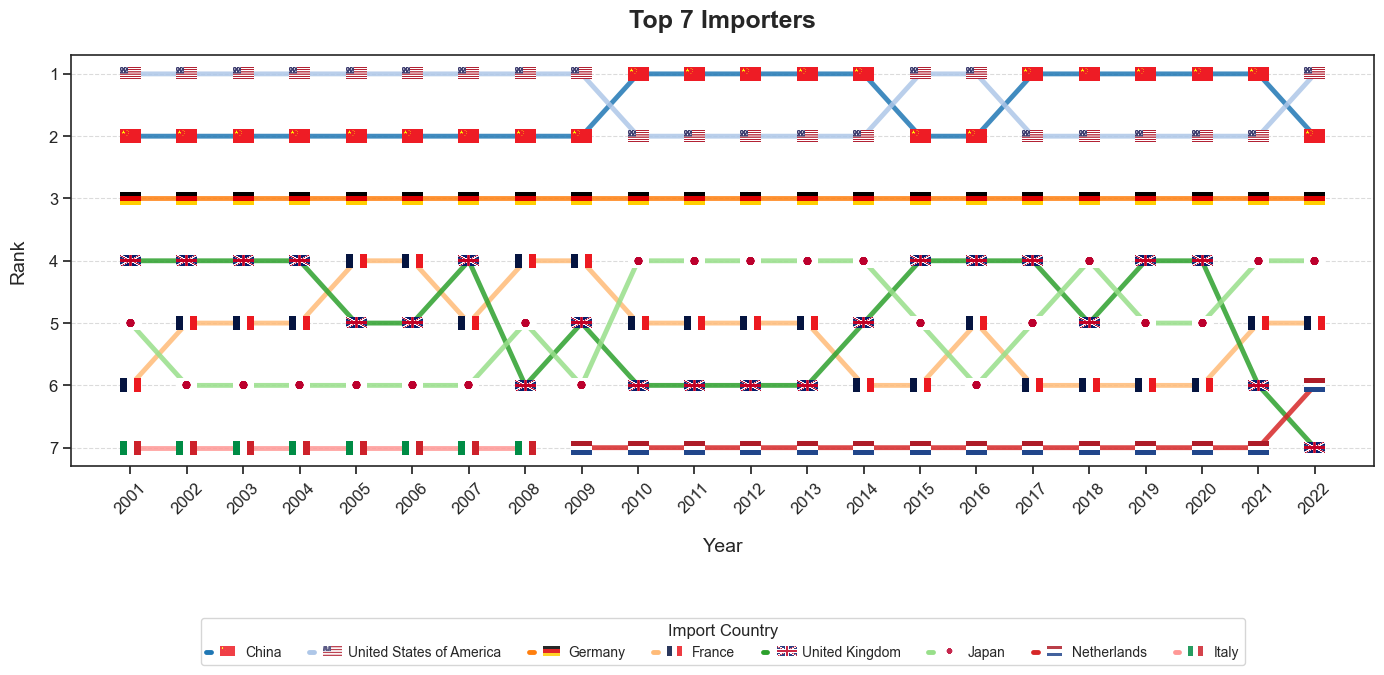

In [63]:
create_bump_chart_with_flags(
    df=df,
    category='import_country',
    top_n=7,
)

### 3) Trade Network Properties

In [64]:
def compute_diameter(G):
    """
    Computes the diameter of the largest connected component of the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Diameter of the largest connected component, or NaN if the graph is empty.

    Interpretation:
        - The diameter is the longest shortest path between any two nodes in the graph.
        - A large diameter indicates a sparse or stretched-out graph, while a small diameter
          suggests a compact or dense graph.
        - For disconnected graphs, the diameter is computed for the largest connected component.
    """
    if G.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G):
        return nx.diameter(G)
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        if G_sub.number_of_nodes() > 1:
            return nx.diameter(G_sub)
        else:
            return 0.0

def compute_degree_assortativity(G):
    """
    Computes the degree assortativity coefficient of the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Degree assortativity coefficient, or NaN if the graph has no edges.

    Interpretation:
        - The degree assortativity measures the tendency of nodes to connect to other nodes
          with a similar degree (number of edges).
        - Values range from -1 to 1:
          - Positive values: High-degree nodes connect to other high-degree nodes.
          - Negative values: High-degree nodes connect to low-degree nodes.
          - Zero: No correlation between degrees of connected nodes.
    """
    if G.number_of_edges() > 0:
        return nx.degree_assortativity_coefficient(G, x='degree')
    else:
        return np.nan

def compute_avg_node_strength(G):
    """
    Computes the average node strength of the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Average node strength, or NaN if the graph is empty.

    Interpretation:
        - Node strength is the sum of the weights of edges connected to a node.
        - The average node strength represents the average amount of interaction (or connection weight)
          per node in the graph.
        - Useful in weighted networks, such as transportation or social interaction graphs.
    """
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = []
    for n in G.nodes():
        strength = sum(d['weight'] for _,_,d in G.edges(n, data=True))
        strengths.append(strength)
    if len(strengths) > 0:
        return np.mean(strengths)
    else:
        return np.nan

def gini_coefficient(values):
    """
    Computes the Gini coefficient of a distribution.

    Parameters:
        values (list or numpy array): Input values.

    Returns:
        float: Gini coefficient, or NaN if the input is empty.

    Interpretation:
        - The Gini coefficient measures inequality in a distribution.
        - Values range from 0 to 1:
          - 0: Perfect equality (all values are the same).
          - 1: Perfect inequality (one value is much larger than the rest).
        - Useful in quantifying the distribution of resources or connectivity in a network.
    """
    arr = np.sort(values)
    n = len(arr)
    if n == 0:
        return np.nan

    cumulative = np.cumsum(arr)
    sum_arr = cumulative[-1]
    if sum_arr == 0:
        return 0.0

    rel_cumulative = cumulative / sum_arr
    return (n + 1 - 2 * np.sum(rel_cumulative) / n)

def compute_gini_node_strength(G):
    """
    Computes the Gini coefficient of node strength in the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Gini coefficient of node strength, or NaN if the graph is empty.

    Interpretation:
        - Measures inequality in the distribution of node strength (sum of edge weights per node).
        - High Gini coefficient: Strength is concentrated in a few nodes (high inequality).
        - Low Gini coefficient: Strength is evenly distributed across nodes (low inequality).
    """
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = [sum(d['weight'] for _,_,d in G.edges(n, data=True)) for n in G.nodes()]
    if len(strengths) == 0:
        return np.nan
    return gini_coefficient(strengths)

def compute_fraction_bridges(G):
    """
    Computes the fraction of edges in the graph that are bridges.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Fraction of edges that are bridges.

    Interpretation:
        - A bridge is an edge whose removal increases the number of connected components in the graph.
        - The fraction of bridges indicates the structural importance of edges in maintaining connectivity.
        - A high fraction suggests a fragile network where many edges are critical for connectivity.
    """
    if G.number_of_edges() == 0:
        return 0.0
    bridges = list(nx.bridges(G))
    return len(bridges) / G.number_of_edges()


In [65]:
results = {
    'year': [],
    'num_nodes': [],
    'num_edges': [],
    'density': [],
    'avg_clustering': [],
    'avg_shortest_path': [],
    'modularity': [],
    'num_communities': [],
    'diameter': [],
    'degree_assortativity': [],
    'avg_node_strength': [],
    'gini_node_strength': [],
    'fraction_bridges': [],
}

for year, graph in yearly_graphs.items():
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    density = nx.density(graph)

    avg_clustering = nx.average_clustering(graph)

    if nx.is_connected(graph):
        avg_shortest_path = nx.average_shortest_path_length(graph)
    else:
        largest_cc = max(nx.connected_components(graph), key=len)
        largest_subgraph = graph.subgraph(largest_cc)
        avg_shortest_path = nx.average_shortest_path_length(largest_subgraph)

    partition = community_louvain.best_partition(graph, weight='weight')
    modularity = community_louvain.modularity(partition, graph, weight='weight')
    num_communities = len(set(partition.values()))

    diameter = compute_diameter(graph)
    degree_assortativity = compute_degree_assortativity(graph)
    avg_node_strength = compute_avg_node_strength(graph)
    gini_node_strength = compute_gini_node_strength(graph)
    fraction_bridges = compute_fraction_bridges(graph)

    results['year'].append(year)
    results['num_nodes'].append(num_nodes)
    results['num_edges'].append(num_edges)
    results['density'].append(density)
    results['avg_clustering'].append(avg_clustering)
    results['avg_shortest_path'].append(avg_shortest_path)
    results['modularity'].append(modularity)
    results['num_communities'].append(num_communities)
    results['diameter'].append(diameter)
    results['degree_assortativity'].append(degree_assortativity)
    results['avg_node_strength'].append(avg_node_strength)
    results['gini_node_strength'].append(gini_node_strength)
    results['fraction_bridges'].append(fraction_bridges)

results_df = pd.DataFrame(results)


In [66]:
def plot_metric(data, x_col, y_col, title, color="black", marker='o', figsize=(5, 4), degree=2):
    """
    Plots a metric with an optional polynomial trend line.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing the data.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis.
        title (str): Title of the plot.
        color (str): Line color for the metric plot.
        marker (str): Marker style for the metric plot.
        figsize (tuple): Figure size (width, height).
        degree (int): Degree of the polynomial trend line (default is 2).
    """
    sns.set_theme(style="ticks")
    plt.rcParams.update({
        "font.family": "Arial",
        "mathtext.fontset": "stix",
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 12,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.8
    })

    plt.figure(figsize=figsize)

    sns.lineplot(data=data, x=x_col, y=y_col, marker=marker, color=color, linewidth=1.5, label='Metric')

    x = data[x_col].astype(float)
    y = data[y_col].astype(float)
    poly_coeffs = np.polyfit(x, y, degree)
    poly_func = np.poly1d(poly_coeffs)
    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = poly_func(x_fit)

    plt.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=1.5, label=f'Polynomial Trend (Degree {degree})')

    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel(x_col.replace("_", " ").title(), fontsize=14)
    plt.ylabel(y_col.replace("_", " ").title(), fontsize=14)
    plt.xticks(data[x_col].unique().astype(int), rotation=90)
    plt.grid(visible=True, linestyle="--", linewidth=0.8, alpha=0.7)
    sns.despine()
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()

    filename = f"{hs_label}_{'_'.join(title.split()).lower()}.png"
    plt.savefig(os.path.join(export_path, filename), dpi=300, bbox_inches="tight", format="png")
    plt.show()


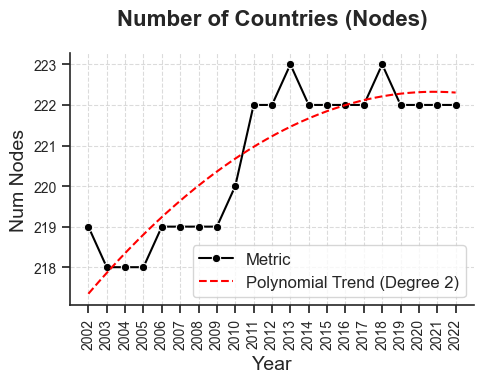

In [67]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_nodes',
    title="Number of Countries (Nodes)"
)

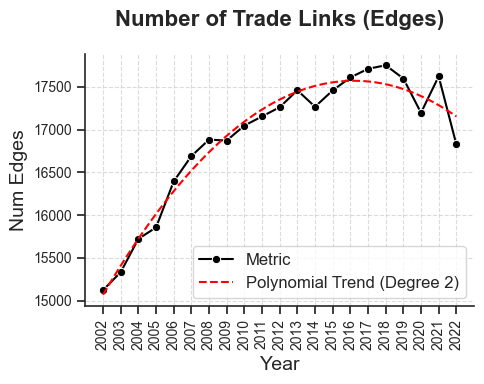

In [68]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_edges',
    title="Number of Trade Links (Edges)"
)

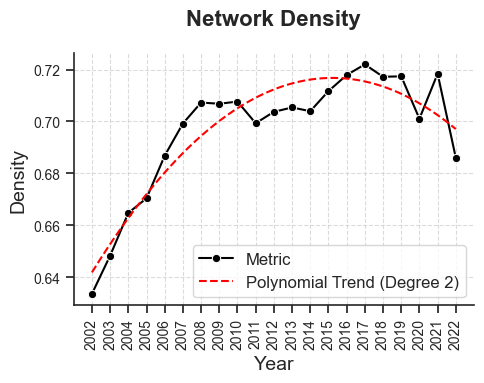

In [69]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='density',
    title="Network Density"
)

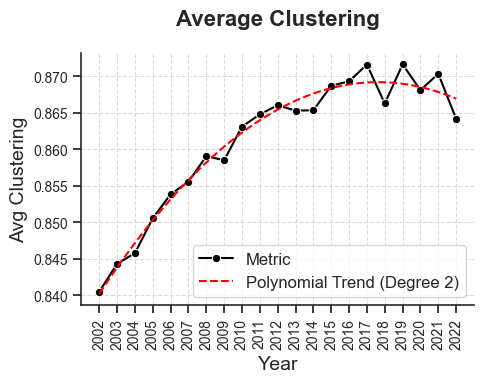

In [70]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_clustering',
    title="Average Clustering"
)

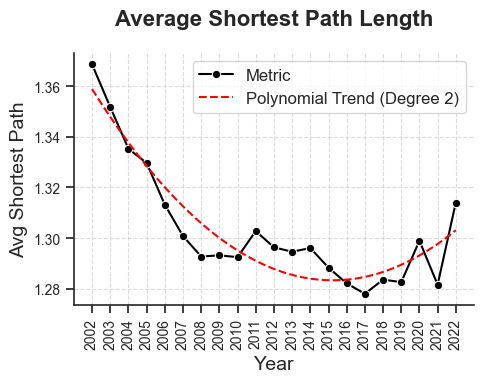

In [71]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_shortest_path',
    title="Average Shortest Path Length"
)

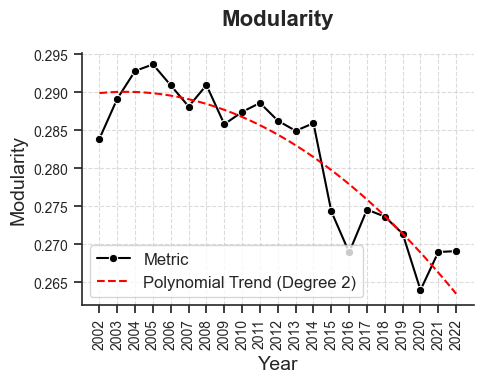

In [72]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='modularity',
    title="Modularity"
)

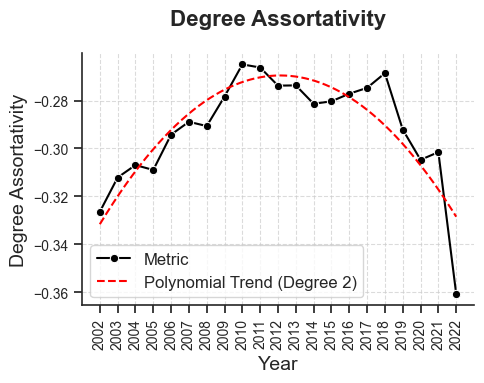

In [73]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='degree_assortativity',
    title="Degree Assortativity"
)

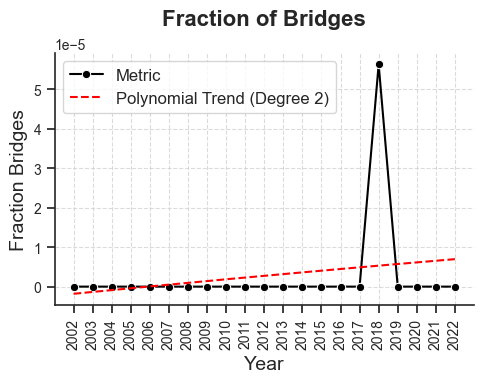

In [74]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='fraction_bridges',
    title="Fraction of Bridges"
)

### 4) Map Visualization of Node Specific Trade Flow

In [75]:
gray_blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_blue",
    ["gray", "blue"]
)

gray_red_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_red",
    ["gray", "red"]
)

Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., US Misc. Pacific Isds, Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat
Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat


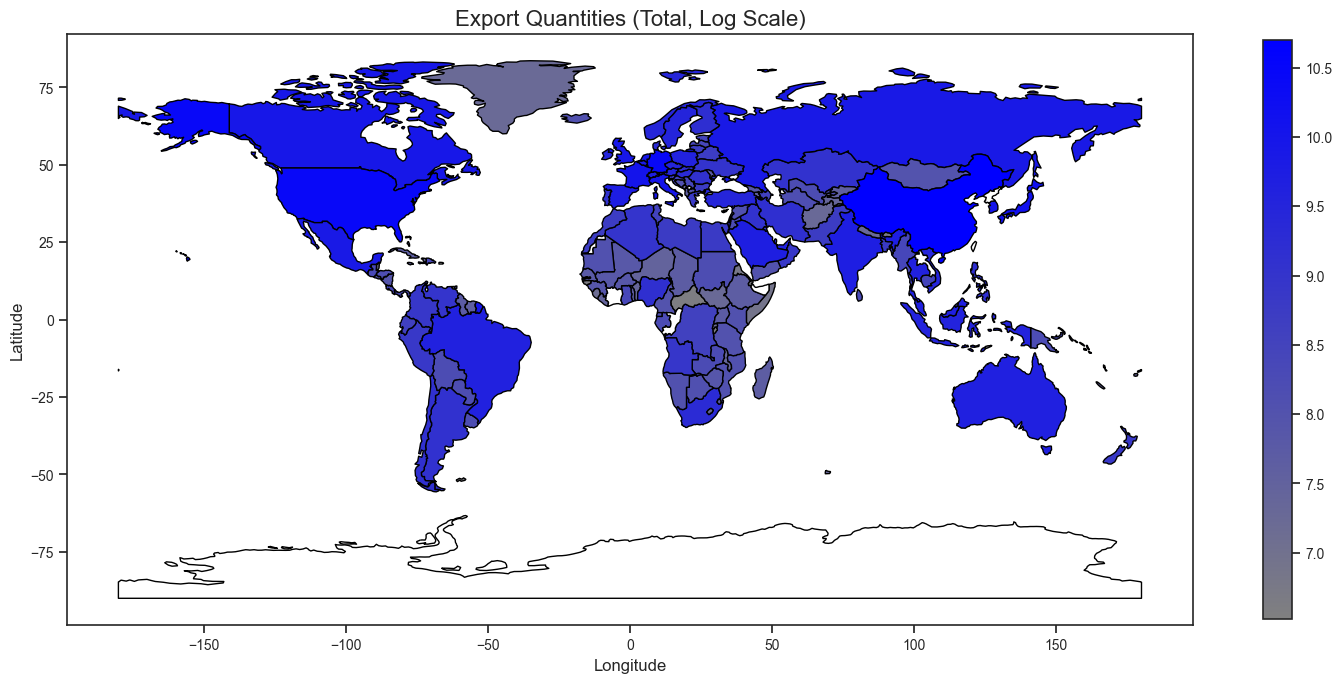

In [76]:
def plot_export_map():
    world_export, _ = loader.preprocess_culture_and_country_names(df)
    world_export["v"] = np.log10(world_export["v"] + 1)

    fig, ax = plt.subplots(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    world_export.plot(
        column="v",
        cmap=gray_blue_cmap,
        legend=True,
        legend_kwds={"shrink": 0.6, "aspect": 20},
        ax=ax,
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax.set_title("Export Quantities (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_export_map.png"), dpi=300, facecolor='white')
    plt.show()

plot_export_map()

Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., US Misc. Pacific Isds, Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat
Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat


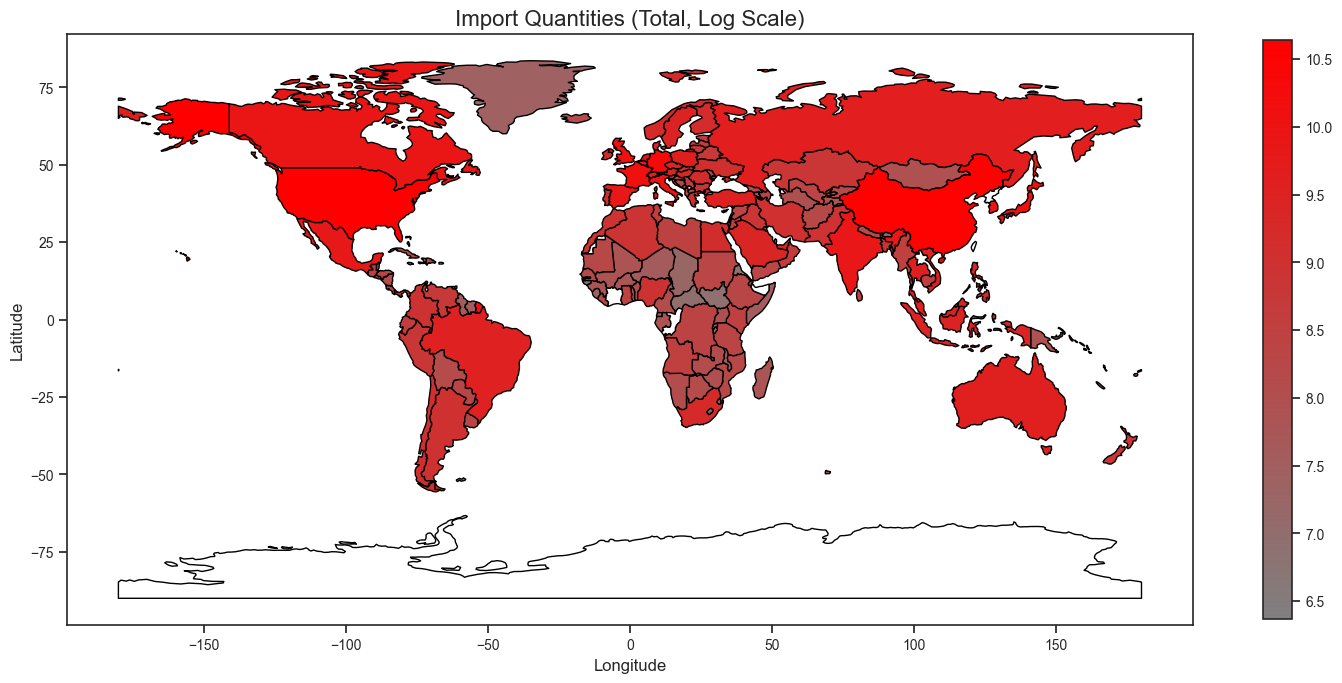

In [77]:
def plot_import_map():
    _, world_import = loader.preprocess_culture_and_country_names(df)
    world_import["v"] = np.log10(world_import["v"] + 1)

    fig, ax = plt.subplots(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    world_import.plot(
        column="v",
        cmap=gray_red_cmap,
        legend=True,
        legend_kwds={"shrink": 0.6, "aspect": 20},  # Adjust the color bar size
        ax=ax,
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax.set_title("Import Quantities (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_import_map.png"), dpi=300, facecolor='white')

    plt.show()

plot_import_map()

Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., US Misc. Pacific Isds, Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat
Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat


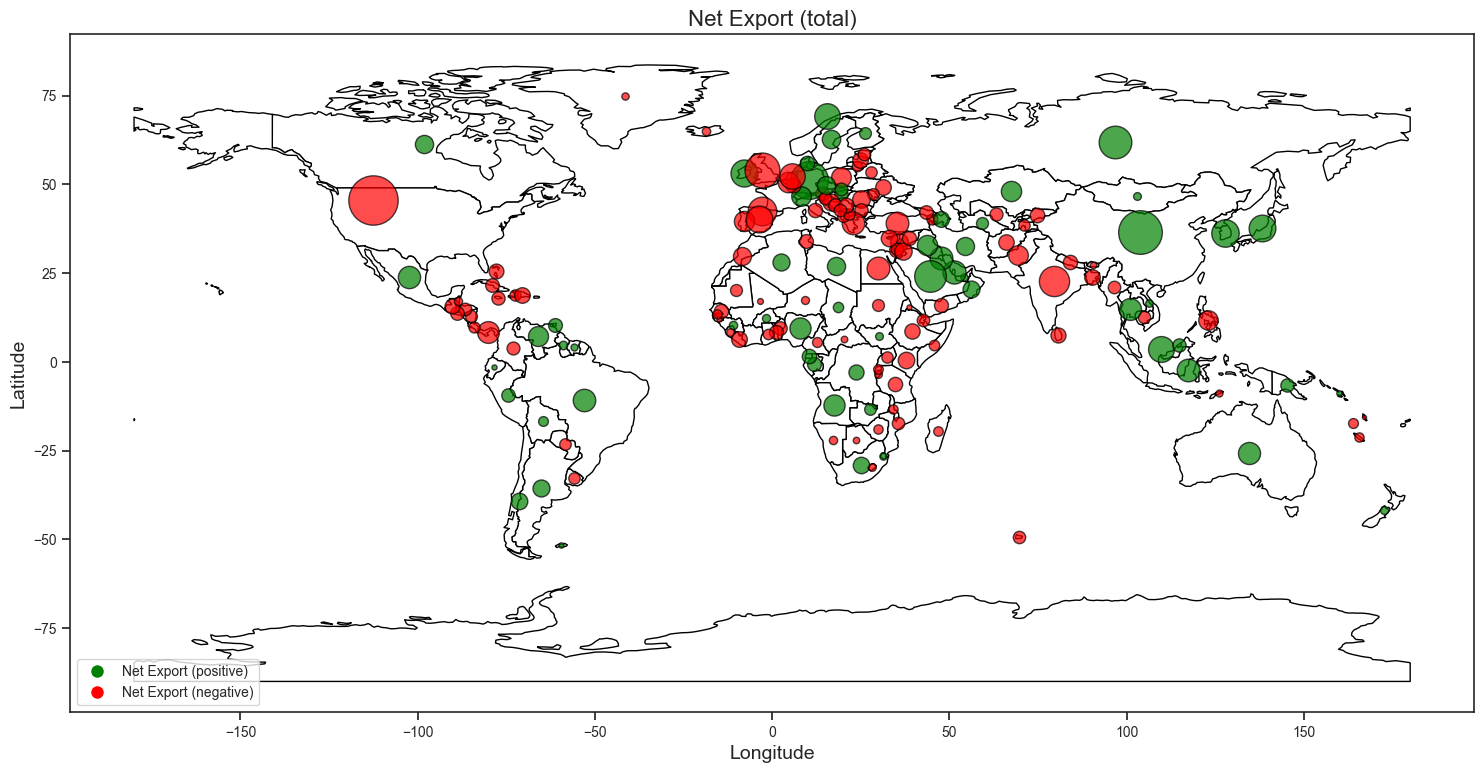

In [78]:
def plot_map_2():
    shapefile_path = os.path.join("data", "dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)
    world_export, world_import = loader.preprocess_culture_and_country_names(df)

    net_export = (
        world_export.set_index("export_country")["v"]
        - world_import.set_index("import_country")["v"]
    ).reset_index()
    net_export.columns = ["country", "net_export"]

    world_net = world.merge(net_export, left_on="ADMIN", right_on="country", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    world.plot(ax=ax, color="white", edgecolor="black")
    ax.set_facecolor('none')

    for _, row in world_net.iterrows():
        if pd.notnull(row["net_export"]) and row["net_export"] != 0:
            size = np.sqrt(abs(row["net_export"])) / 100
            color = "green" if row["net_export"] > 0 else "red"
            ax.scatter(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                s=size,
                color=color,
                alpha=0.7,
                edgecolor="black"
            )

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Net Export (positive)"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Net Export (negative)"),
    ]
    ax.legend(handles=handles, loc="lower left", fontsize="small")

    ax.set_title(f"Net Export (total)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_net_export_map_2.png"), dpi=300, transparent=True)
    plt.show()

plot_map_2()


Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., US Misc. Pacific Isds, Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat
Unmapped Names: Cayman Isds, Comoros, Bonaire, Andorra, San Marino, Tuvalu, Bahrain, Curaçao, Niue, Palau, Cocos Isds, Lao People's Dem. Rep., Côte d'Ivoire, American Samoa, Bermuda, Tokelau, Cook Isds, Cabo Verde, Maldives, Samoa, Tonga, Br. Virgin Isds, Seychelles, Marshall Isds, Christmas Isds, Aruba, Singapore, Pitcairn, Barbados, Kiribati, Norfolk Isds, N. Mariana Isds, Nauru, Montserrat


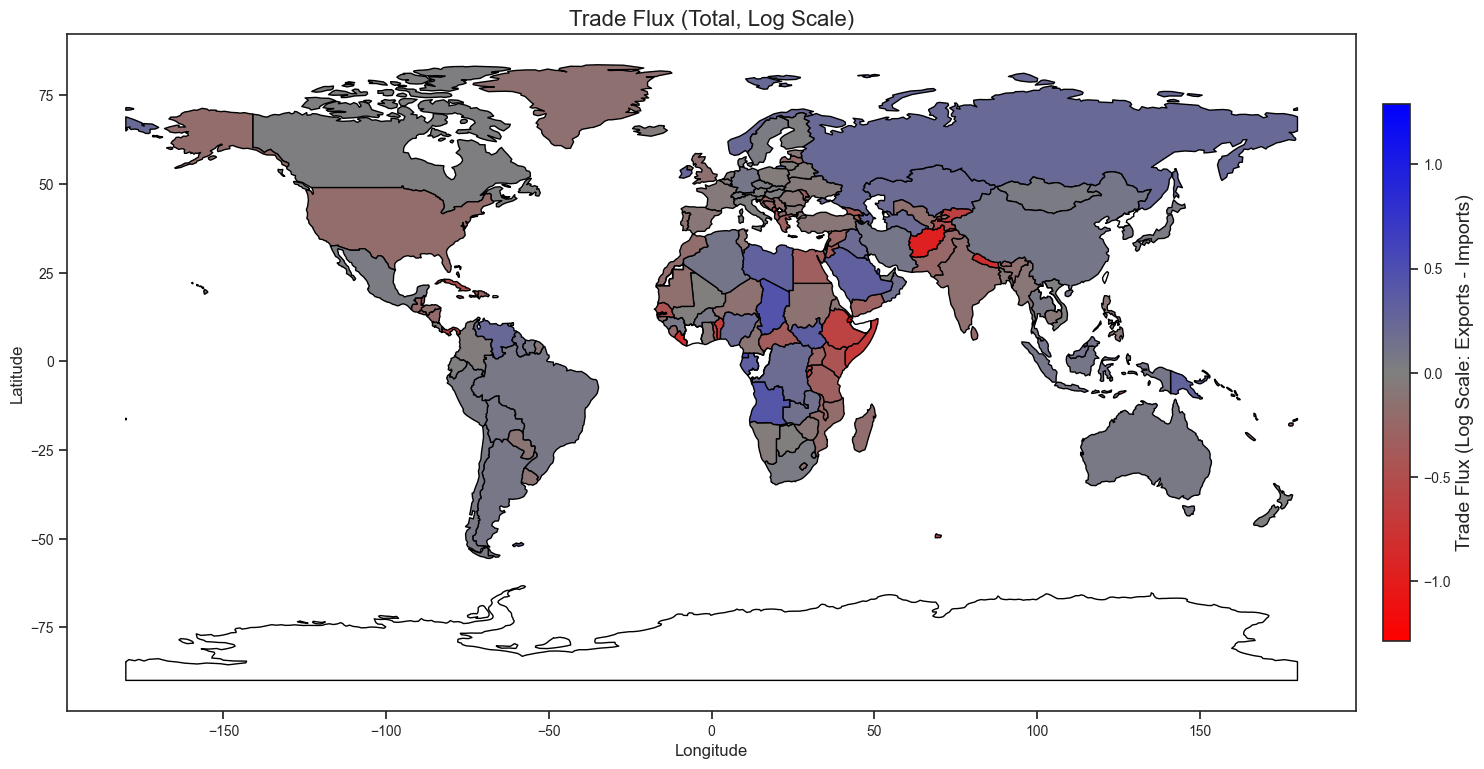

In [79]:
def plot_flux():
    world_export, world_import = loader.preprocess_culture_and_country_names(df)

    world_export["v"] = np.log10(world_export["v"] + 1)
    world_import["v"] = np.log10(world_import["v"] + 1)

    world_flux = world_export[["ADMIN", "geometry", "v"]].merge(
        world_import[["ADMIN", "v"]], on="ADMIN", suffixes=("_exp", "_imp")
    )
    world_flux["flux"] = world_flux["v_exp"] - world_flux["v_imp"]

    vmax = world_flux["flux"].abs().max()

    flux_cmap = mcolors.LinearSegmentedColormap.from_list("flux_cmap", ["red", "gray", "blue"])
    norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    fig.patch.set_alpha(0)
    ax.set_facecolor((0, 0, 0, 0))

    world_flux.plot(
        column="flux",
        cmap=flux_cmap,
        norm=norm,
        legend=False,
        ax=ax,
        missing_kwds={"color": "none"},
        edgecolor="black"
    )

    sm = plt.cm.ScalarMappable(norm=norm, cmap=flux_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Trade Flux (Log Scale: Exports - Imports)")

    ax.set_title(f"Trade Flux (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(
        os.path.join(export_path, f"{hs_label}_trade_flux_map.png"),
        dpi=300,
        transparent=True
    )
    plt.show()

plot_flux()


### 5) Theoretical Graph Properties

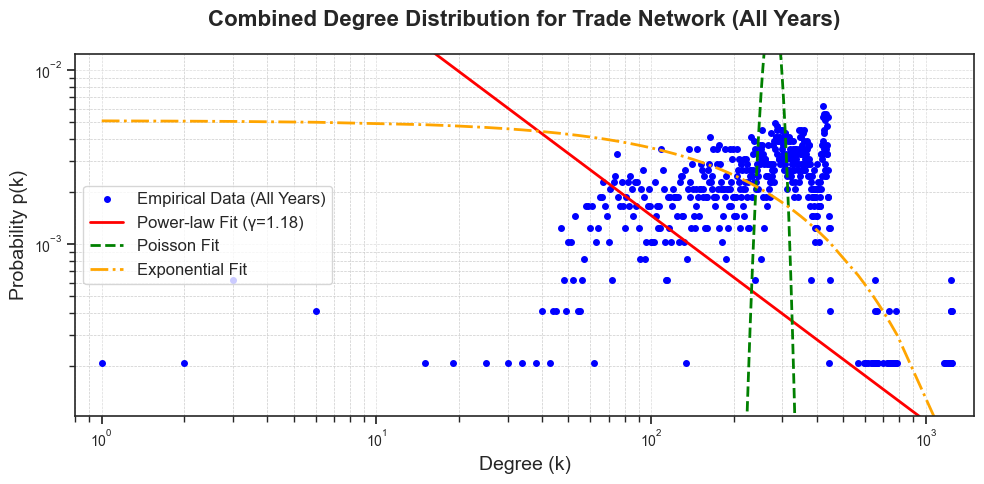

In [80]:
def compute_country_statistics(df):
    export_stats = df.groupby(["t", "export_country"])["v"].size().reset_index(name="num_exports")
    import_stats = df.groupby(["t", "import_country"])["v"].size().reset_index(name="num_imports")

    country_stats = pd.merge(
        export_stats,
        import_stats,
        left_on=["t", "export_country"],
        right_on=["t", "import_country"],
        how="outer"
    ).fillna(0)

    country_stats.rename(columns={"export_country": "country", "import_country": "country"}, inplace=True)

    country_stats["degree"] = country_stats["num_exports"] + country_stats["num_imports"]

    return country_stats[["t", "country", "degree"]]

def plot_degree_distribution_combined(df, name):
    # Combine degree sequences from all years
    degree_sequence = df["degree"].values
    k_values, counts = np.unique(degree_sequence, return_counts=True)
    probs = counts / counts.sum()

    nonzero = probs > 0
    k_values = k_values[nonzero]
    probs = probs[nonzero]

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot combined degree distribution
    ax.loglog(k_values, probs, 'o', label="Empirical Data (All Years)", color='blue', markersize=4)

    # Power-law fit
    gamma = 1 + len(degree_sequence) / np.sum(np.log(degree_sequence / degree_sequence.min()))
    y_powerlaw = k_values ** (-gamma)
    y_powerlaw /= y_powerlaw.sum()  # Normalize
    ax.loglog(k_values, y_powerlaw, label=f"Power-law Fit (γ={gamma:.2f})", color='red', linewidth=2)

    # Poisson fit
    lambda_poisson = np.mean(degree_sequence)
    y_poisson = stats.poisson.pmf(k_values, lambda_poisson)
    y_poisson /= y_poisson.sum()  # Normalize
    ax.loglog(k_values, y_poisson, label="Poisson Fit", color='green', linestyle='--', linewidth=2)

    # Exponential fit
    y_exponential = (1 / lambda_poisson) * np.exp(-k_values / lambda_poisson)
    y_exponential /= y_exponential.sum()  # Normalize
    ax.loglog(k_values, y_exponential, label="Exponential Fit", color='orange', linestyle='-.', linewidth=2)

    ax.set_xlim([0.8 * k_values.min(), k_values.max() * 1.2])
    ax.set_ylim([0.5 * probs.min(), probs.max() * 2])

    ax.set_title(
        f"Combined Degree Distribution for {name} (All Years)",
        fontsize=16,
        fontweight="bold",
        pad=20
    )
    ax.set_xlabel("Degree (k)", fontsize=14)
    ax.set_ylabel("Probability p(k)", fontsize=14)
    ax.grid(visible=True, linestyle="--", linewidth=0.8, alpha=0.7)
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.savefig(
        os.path.join(export_path, f"{hs_label}_degree_distribution.png"),
        dpi=300,
        transparent=True
    )
    plt.show()


country_stats = compute_country_statistics(df)

plot_degree_distribution_combined(country_stats, "Trade Network")


### 6) Centrality Analysis


Centrality Distributions and Summary Statistics for Lithium Trade Network:

Heterogeneity parameter: 1.1094

Degree Centrality:
Mean: 154.9369, Median: 168.0000, Std Dev: 51.2404, Max: 221.0000, Min: 36.0000
Proportion of zeros: 0.00%

Closeness Centrality:
Mean: 0.7932, Median: 0.8066, Std Dev: 0.1326, Max: 1.0000, Min: 0.5443
Proportion of zeros: 0.00%

Betweenness Centrality:
Mean: 0.0014, Median: 0.0009, Std Dev: 0.0015, Max: 0.0047, Min: 0.0000
Proportion of zeros: 0.00%

Eigenvector Centrality:
Mean: 0.0646, Median: 0.0710, Std Dev: 0.0183, Max: 0.0842, Min: 0.0172
Proportion of zeros: 0.00%



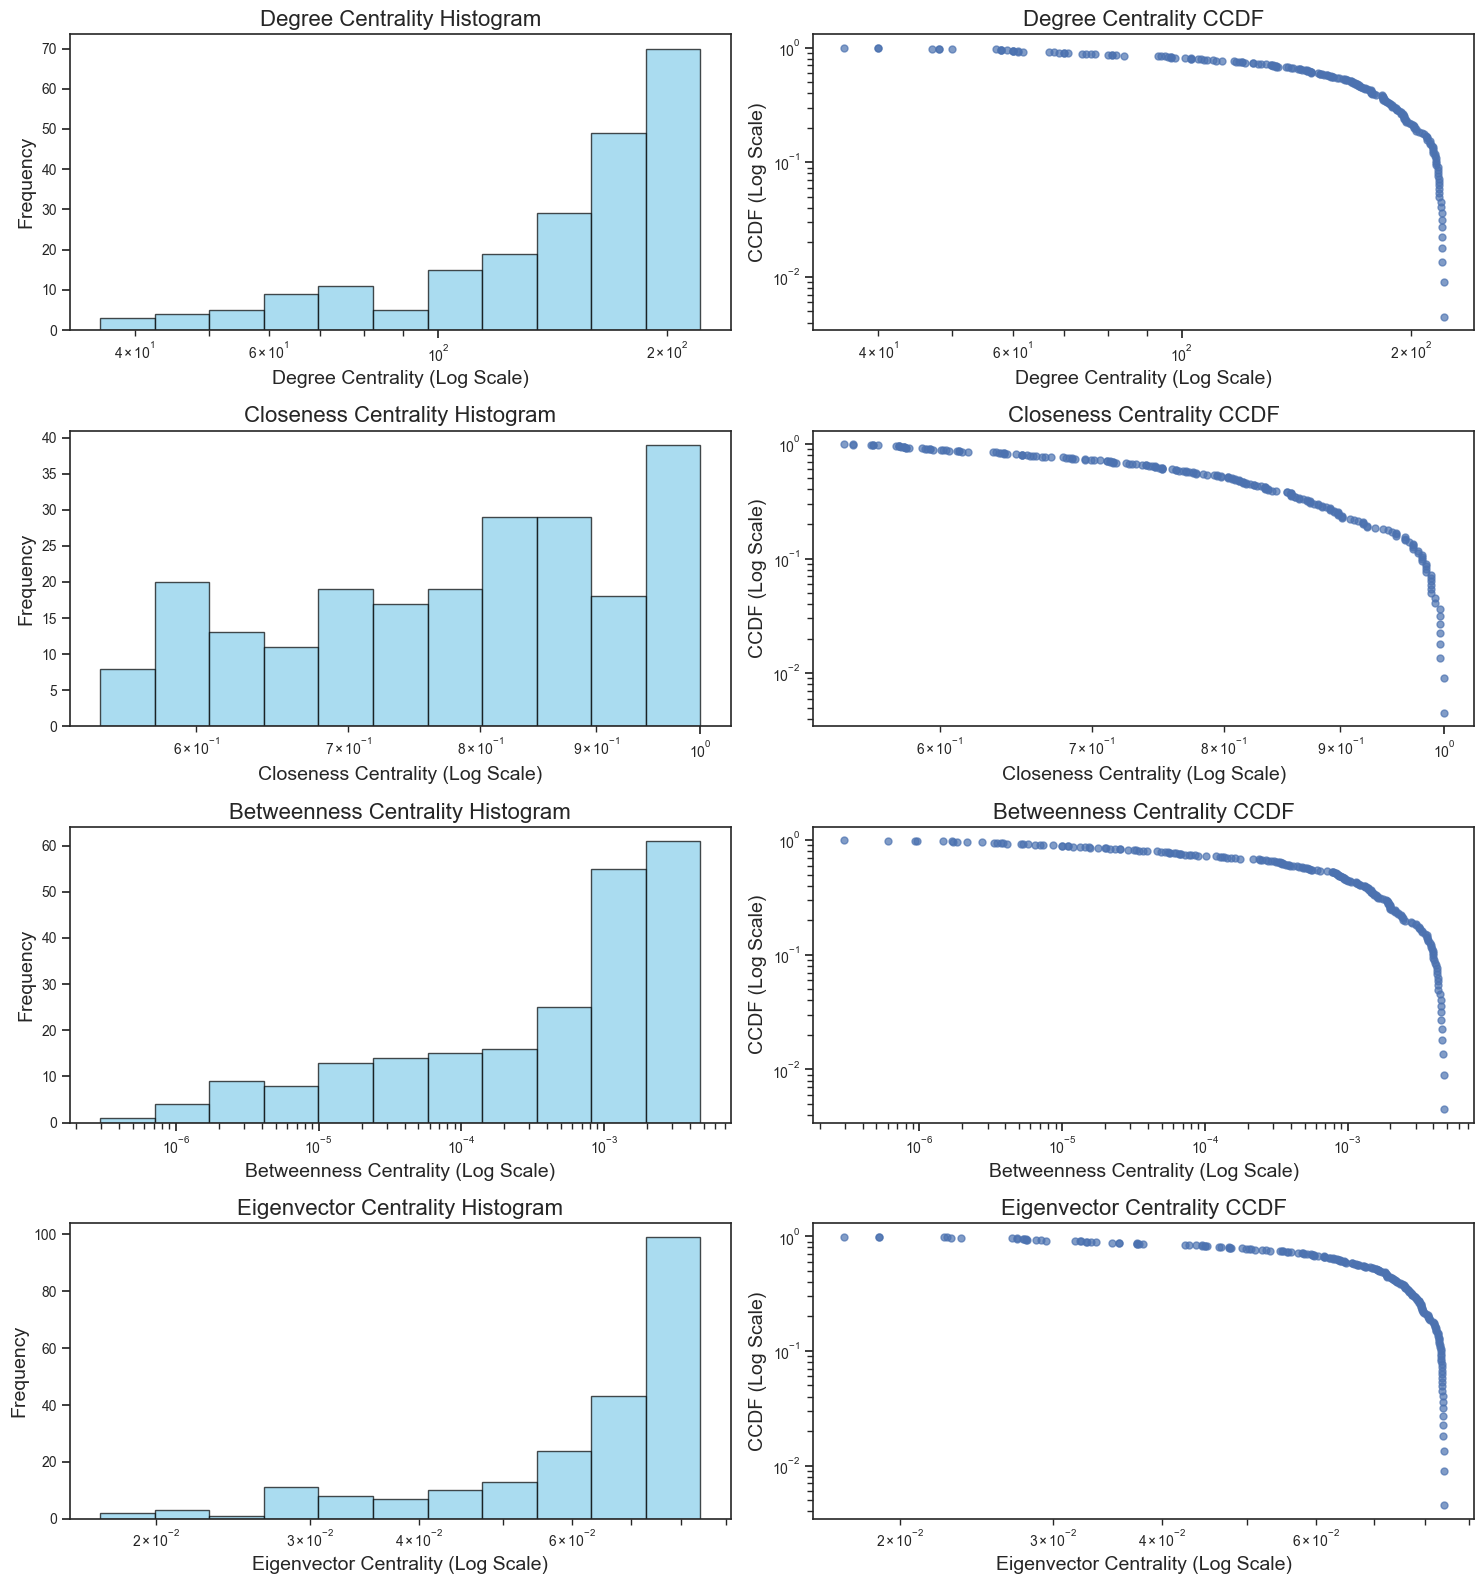

In [81]:
def compare_centralities(G):
    graph_name = "Lithium Trade Network"

    degrees = dict(G.degree())
    mean_degree = np.mean(list(degrees.values()))
    mean_degree_squared = np.mean(np.square(list(degrees.values())))
    heterogeneity = mean_degree_squared / (mean_degree ** 2)
    closeness_centralities = nx.closeness_centrality(G)
    betweenness_centralities = nx.betweenness_centrality(G)
    eigenvector_centralities = nx.eigenvector_centrality(G, max_iter=1000)

    centrality_measures = {
        "Degree": degrees,
        "Closeness": closeness_centralities,
        "Betweenness": betweenness_centralities,
        "Eigenvector": eigenvector_centralities
    }

    centrality_values = {k: list(v.values()) for k, v in centrality_measures.items()}

    centrality_names = list(centrality_measures.keys())
    N_ROWS = len(centrality_names)
    fig1, axes1 = plt.subplots(N_ROWS, 2, figsize=(15, 4 * N_ROWS))
    if N_ROWS == 1:
        axes1 = [axes1]

    print(f"\nCentrality Distributions and Summary Statistics for {graph_name}:\n")
    print(f"Heterogeneity parameter: {heterogeneity:.4f}\n")
    for i, centrality_name in enumerate(centrality_names):
        values = centrality_values[centrality_name]

        mean_val = np.mean(values)
        median_val = np.median(values)
        std_val = np.std(values)
        max_val = np.max(values)
        min_val = np.min(values)
        zero_count = values.count(0)
        zero_proportion = zero_count / len(values)
        print(f"{centrality_name} Centrality:")
        print(f"Mean: {mean_val:.4f}, Median: {median_val:.4f}, Std Dev: {std_val:.4f}, "
              f"Max: {max_val:.4f}, Min: {min_val:.4f}")
        print(f"Proportion of zeros: {zero_proportion:.2%}\n")

        ax_hist = axes1[i][0]
        epsilon = 1e-10
        adjusted_values = [v if v > 0 else epsilon for v in values]
        num_bins = int(2 * len(adjusted_values) ** (1/3))  # Rice Rule
        bins = np.logspace(np.log10(min(adjusted_values)), np.log10(max(adjusted_values)), num_bins)
        ax_hist.hist(adjusted_values, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
        ax_hist.set_xscale('log')
        ax_hist.set_xlabel(f"{centrality_name} Centrality (Log Scale)")
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_title(f"{centrality_name} Centrality Histogram")
        ax_ccdf = axes1[i][1]
        positive_values = [v for v in values if v > 0]

        sorted_values = np.sort(positive_values)
        ccdf = 1.0 - np.arange(1, len(sorted_values) + 1) / len(sorted_values)

        ax_ccdf.plot(sorted_values, ccdf, marker='o', linestyle='none', markersize=5, alpha=0.7)
        ax_ccdf.set_xscale('log')
        ax_ccdf.set_yscale('log')
        ax_ccdf.set_xlabel(f"{centrality_name} Centrality (Log Scale)")
        ax_ccdf.set_ylabel("CCDF (Log Scale)")
        ax_ccdf.set_title(f"{centrality_name} Centrality CCDF")

    plt.tight_layout()
    plt.savefig(
        os.path.join(export_path, f"{hs_label}_centrality_analysis.png"),
        dpi=300,
        transparent=True
    )
    plt.show()

compare_centralities(yearly_graphs[2020])

### Community Detection

In [82]:
TG = tx.TemporalMultiDiGraph()

for year, G in yearly_graphs.items():
    for u, v, data in G.edges(data=True):
        TG.add_edge(u, v, time=year, **data)

TG = TG.slice(attr="time")

# tx.draw(TG, figsize=(8, 2))


In [83]:
snapshots = TG.to_snapshots("igraph")

temporal_membership, improvement = la.find_partition_temporal(
    snapshots,
    la.ModularityVertexPartition,
    interslice_weight=5,
    n_iterations=-1,
    seed=42,
    vertex_id_attr="_nx_name",
    weight_attr="inverse_weight"
)

cmap = plt.cm.get_cmap("tab10")
max_community = max(max(membership) for membership in temporal_membership)  # No .values()
community_colors = {i: mcolors.to_hex(cmap(i / max_community)) for i in range(max_community + 1)}


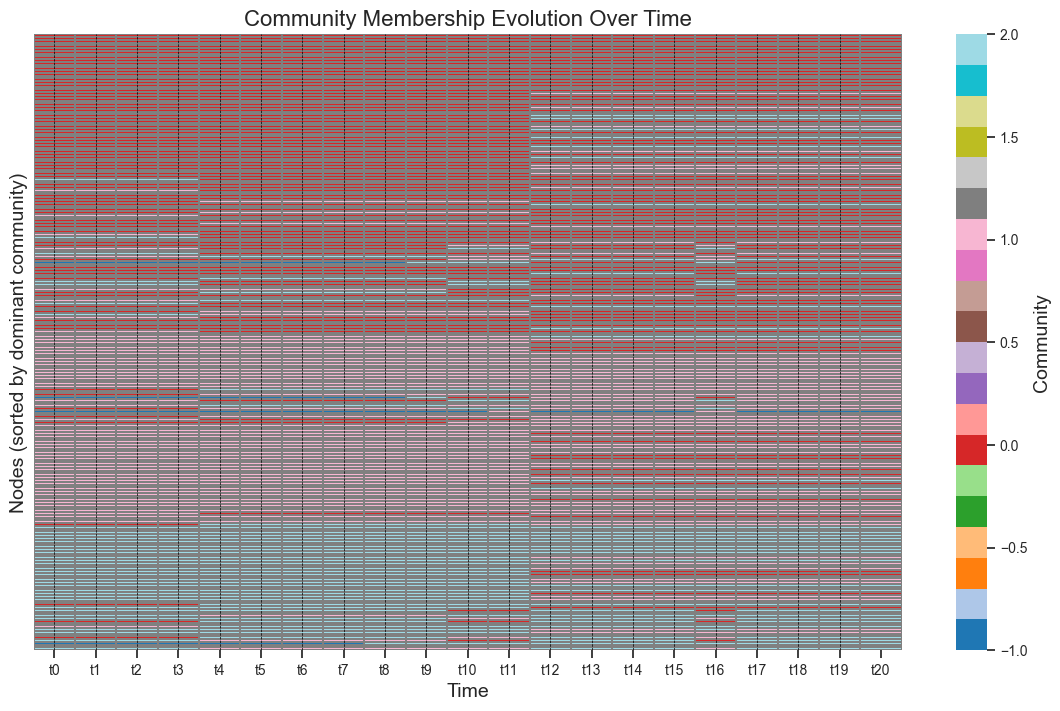

In [84]:
all_nodes = set()
for membership in temporal_membership:
    all_nodes.update(range(len(membership)))

all_nodes = sorted(all_nodes)
node_to_index = {node: i for i, node in enumerate(all_nodes)}

node_community_matrix = np.full((len(all_nodes), len(temporal_membership)), -1)

for t, membership in enumerate(temporal_membership):
    for node, community in enumerate(membership):
        node_community_matrix[node_to_index[node], t] = community

dominant_communities = np.array([np.bincount(row[row >= 0]).argmax() for row in node_community_matrix])
sorted_indices = np.argsort(dominant_communities)
sorted_matrix = node_community_matrix[sorted_indices]

plt.figure(figsize=(14, 8))
sns.heatmap(
    sorted_matrix,
    cmap="tab20",
    cbar_kws={"label": "Community"},
    xticklabels=[f"t{t}" for t in range(len(temporal_membership))],
    yticklabels=False,
    linewidths=0.1,
    linecolor="gray",
)

plt.xlabel("Time")
plt.ylabel("Nodes (sorted by dominant community)")
plt.title("Community Membership Evolution Over Time")

num_time_slices = len(temporal_membership)
for t in range(num_time_slices - 1):
    plt.axvline(t + 0.5, color="black", linestyle="--", linewidth=0.5)

plt.savefig(
    os.path.join(export_path, f"{hs_label}_temp_community_heatmap.png"),
    dpi=300,
    transparent=True
)
plt.show()


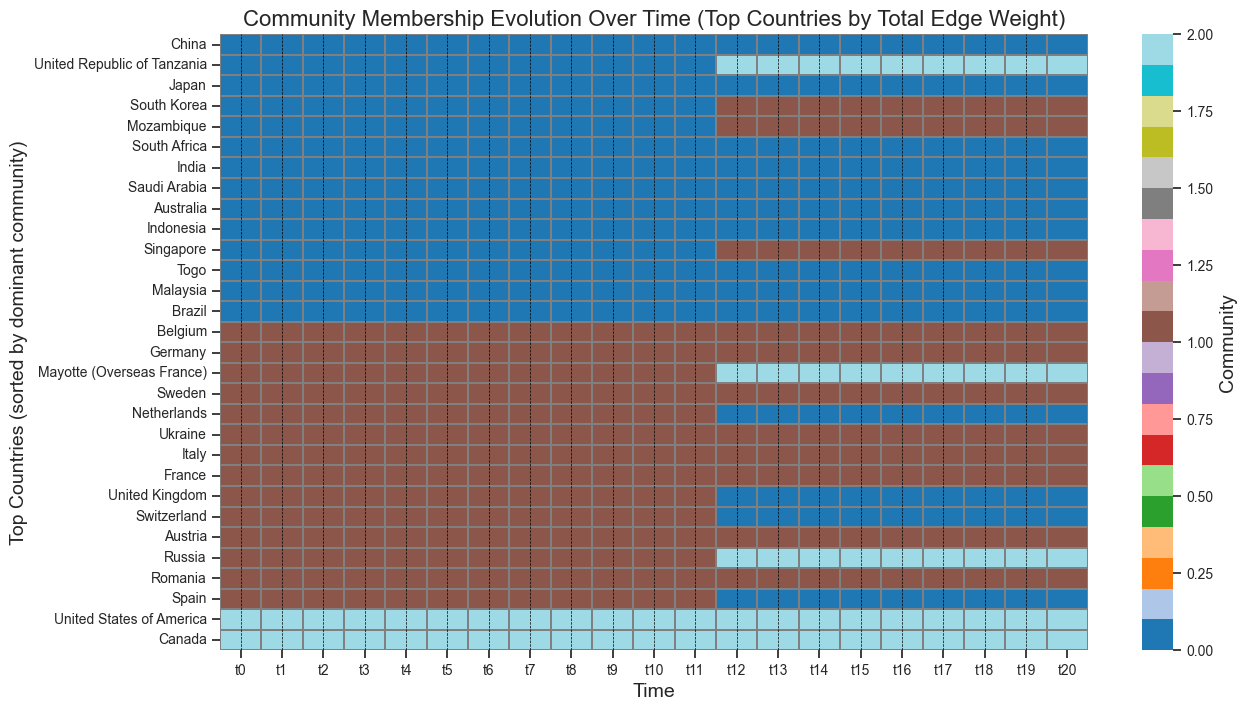

In [85]:
node_to_country = {v.index: v["_nx_name"] for v in snapshots[0].vs}

node_weights = {}

for t, snapshot in enumerate(snapshots):
    for edge in snapshot.es:
        source = edge.source
        target = edge.target
        weight = edge["weight"] if "weight" in edge.attributes() else 0
        node_weights[source] = node_weights.get(source, 0) + weight
        node_weights[target] = node_weights.get(target, 0) + weight

top_n = 30
most_relevant_nodes = sorted(node_weights, key=node_weights.get, reverse=True)[:top_n]
most_relevant_countries = [node_to_country[node] for node in most_relevant_nodes]
most_relevant_indices = {node: idx for idx, node in enumerate(most_relevant_nodes)}

node_community_matrix_relevant = np.full((len(most_relevant_nodes), len(temporal_membership)), -1)

for t, membership in enumerate(temporal_membership):
    for node, community in enumerate(membership):
        if node in most_relevant_indices:
            node_community_matrix_relevant[most_relevant_indices[node], t] = community

dominant_communities_relevant = np.array([
    np.bincount(row[row >= 0]).argmax() if len(row[row >= 0]) > 0 else -1
    for row in node_community_matrix_relevant
])
sorted_indices_relevant = np.argsort(dominant_communities_relevant)
sorted_matrix_relevant = node_community_matrix_relevant[sorted_indices_relevant]

plt.figure(figsize=(14, 8))
sns.heatmap(
    sorted_matrix_relevant,
    cmap="tab20",
    cbar_kws={"label": "Community"},
    xticklabels=[f"t{t}" for t in range(len(temporal_membership))],
    yticklabels=[most_relevant_countries[i] for i in sorted_indices_relevant],
    linewidths=0.1,
    linecolor="gray",
)

plt.xlabel("Time")
plt.ylabel("Top Countries (sorted by dominant community)")
plt.title("Community Membership Evolution Over Time (Top Countries by Total Edge Weight)")

num_time_slices = len(temporal_membership)
for t in range(num_time_slices - 1):
    plt.axvline(t + 0.5, color="black", linestyle="--", linewidth=0.5)

plt.savefig(os.path.join(export_path, f"{hs_label}_heatmap_top_countries.png"), dpi=300, bbox_inches="tight", format="png")
plt.show()


### Gini Coefficient

In [86]:
yearly_exports = (
    df.groupby(["t", "export_country"], as_index=False)["v"].sum()
)

In [87]:
def calculate_export_metrics(yearly_exports):
    years_list = []
    hhi_list = []
    top5_share_list = []
    gini_list = []
    total_volume_list = []

    for year, grp in yearly_exports.groupby("t"):
        total_exports = grp["v"].sum()
        shares = grp["v"] / total_exports

        # HHI (Herfindahl-Hirschman Index)
        hhi = (shares ** 2).sum()

        # Top 5 Exporter Share
        sorted_shares = np.sort(shares)[::-1]
        top5 = sorted_shares[:5].sum() if len(sorted_shares) >= 5 else sorted_shares.sum()

        # Gini Coefficient of Exporter Share
        gini_val = gini_coefficient(shares.values)

        years_list.append(year)
        hhi_list.append(hhi)
        top5_share_list.append(top5)
        gini_list.append(gini_val)
        total_volume_list.append(total_exports)

    return pd.DataFrame({
        "year": years_list,
        "HHI": hhi_list,
        "Top5_Share": top5_share_list,
        "Gini_Shares": gini_list,
        "Total_Volume": total_volume_list
    })


metrics_df = calculate_export_metrics(yearly_exports)

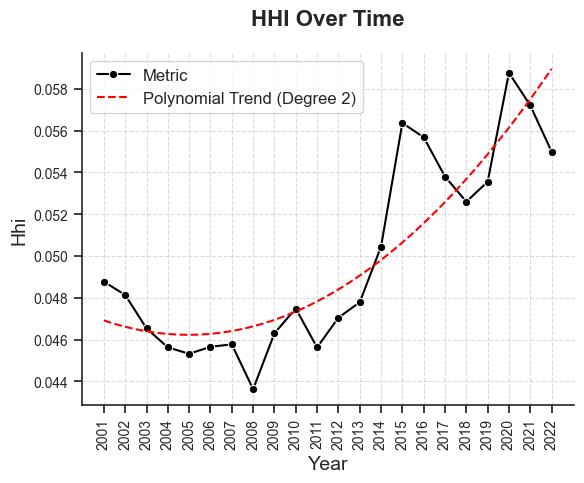

In [88]:
def plot_hhi(metrics_df):
    plot_metric(
        data=metrics_df,
        x_col="year",
        y_col="HHI",
        title="HHI Over Time",
        color="black",
        marker='o',
        figsize=(6, 5),
        degree=2
    )
plot_hhi(metrics_df)

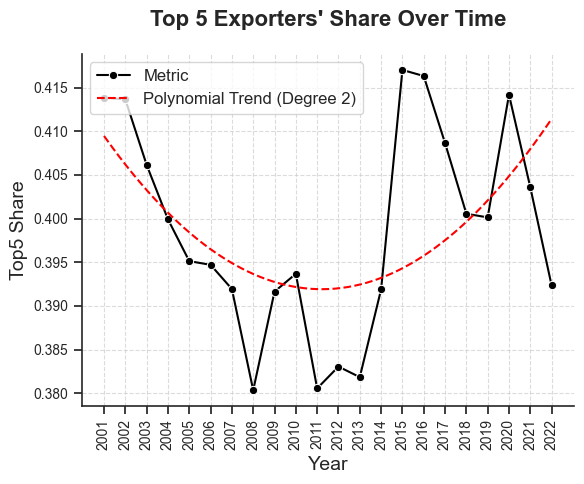

In [89]:
def plot_top5_share(metrics_df):
    plot_metric(
        data=metrics_df,
        x_col="year",
        y_col="Top5_Share",
        title="Top 5 Exporters' Share Over Time",
        color="black",
        marker='o',
        figsize=(6, 5),
        degree=2
    )
plot_top5_share(metrics_df)

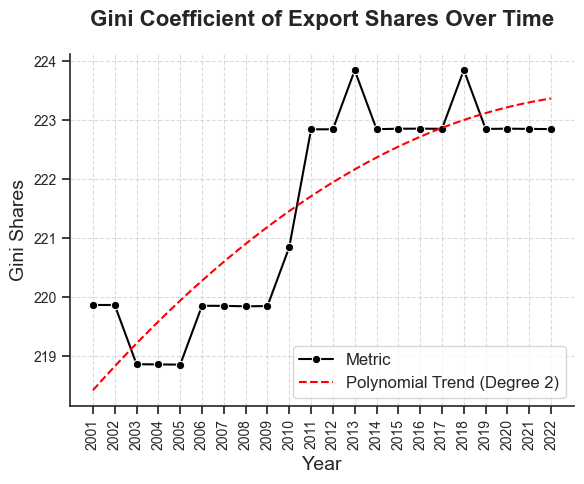

In [90]:
def plot_gini(metrics_df):
    plot_metric(
        data=metrics_df,
        x_col="year",
        y_col="Gini_Shares",
        title="Gini Coefficient of Export Shares Over Time",
        color="black",
        marker='o',
        figsize=(6, 5),
        degree=2
    )
plot_gini(metrics_df)

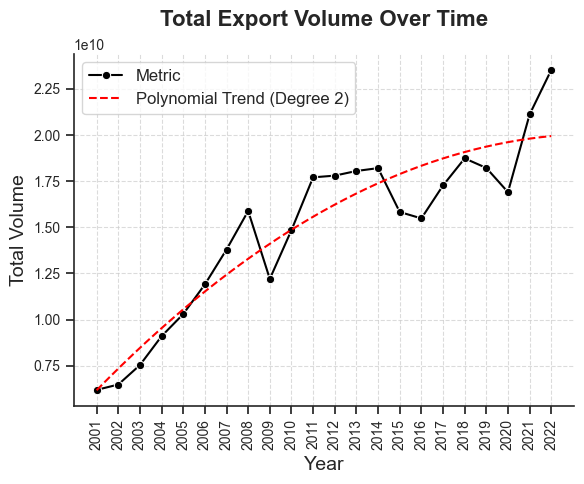

In [91]:
def plot_total_volume(metrics_df):
    plot_metric(
        data=metrics_df,
        x_col="year",
        y_col="Total_Volume",
        title="Total Export Volume Over Time",
        color="black",
        marker='o',
        figsize=(6, 5),
        degree=2
    )
plot_total_volume(metrics_df)

### Centrality Analysis

In [92]:
crises = [
    (2008, 2009, "World Economic Crisis", '#d3d3d3'),
    (2014, 2015, "Oil Price Crash", '#ffa500'),
    (2018, 2020, "Trump vs. China Trade War", '#90ee90'),
    (2020, 2022, "COVID Pandemic", '#add8e6'),
    (2020, 2022, "Chip Crisis", '#e6e6fa'),
    (2022, 2023, "Russian Attack on Ukraine", '#ff9999'),
]

In [93]:
def compute_func_over_time(yearly_graphs, func, weight, **kwargs):
    centrality_data = []
    for year, graph in yearly_graphs.items():
        if weight:
            edge_attribute_keys = {key for _, _, attr in graph.edges(data=True) for key in attr.keys()}
            if weight not in edge_attribute_keys:
                raise ValueError(f"Invalid weight attribute: {weight}")

            if func == nx.degree_centrality:
                total_weight = sum(1 for _, _, _ in graph.edges(data=True))
                metric_values = {node: sum(1 for _, _, _ in graph.edges(node, data=True)) / total_weight
                                 for node in graph.nodes()}
            else:
                metric_values = func(graph, weight=weight, **kwargs)

        for node, value in metric_values.items():
            centrality_data.append({'node': node, 'year': year, func.__name__: value})
    return pd.DataFrame(centrality_data)


In [94]:
def plot_func_trends(centrality_df, top_n, func_name):
    top_nodes = (
        centrality_df.groupby('node')[func_name]
        .mean()
        .nlargest(top_n)
        .index
    )
    name = " ".join(func_name.split("_")).title()
    filtered_df = centrality_df[centrality_df['node'].isin(top_nodes)]
    pivot_df = filtered_df.pivot(index='year', columns='node', values=func_name)

    fig, ax = plt.subplots(figsize=(6, 5))

    pivot_df.plot(ax=ax, marker='o', legend=False)

    overlapping_colors = ['#d3d3d3', '#ffdd44', '#90ee90', '#add8e6', '#e6e6fa', '#ff9999']

    for i, (start, end, label, color) in enumerate(crises):
        ax.axvspan(start, end, color=overlapping_colors[i], alpha=0.5, zorder=0)

    country_handles = [
        plt.Line2D([0], [0], color=ax.lines[i].get_color(), lw=2, marker='o', label=node)
        for i, node in enumerate(top_nodes)
    ]

    crisis_handles = [
        plt.Line2D([0], [0], color=overlapping_colors[i], lw=8, alpha=0.5, label=label)
        for i, (_, _, label, _) in enumerate(crises)
    ]

    fig.legend(
        handles=country_handles + crisis_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=2,
        fontsize="small",
        title="Legends"
    )

    plt.title(f'{name} Trends Over Time')
    plt.xlabel('Year')
    plt.xticks(ticks=range(2002, 2024), rotation=90)
    plt.ylabel(name.title())
    plt.grid(color="white")
    plt.tight_layout()
    plt.savefig(os.path.join(export_path, f"{hs_label}_{func_name}.png"), dpi=300, bbox_inches="tight", format="png")
    plt.show()


In [95]:
def process_visualization(yearly_graphs, func, top_n, weight):
    centrality_df = compute_func_over_time(yearly_graphs, func, weight)
    plot_func_trends(centrality_df, top_n, func.__name__)

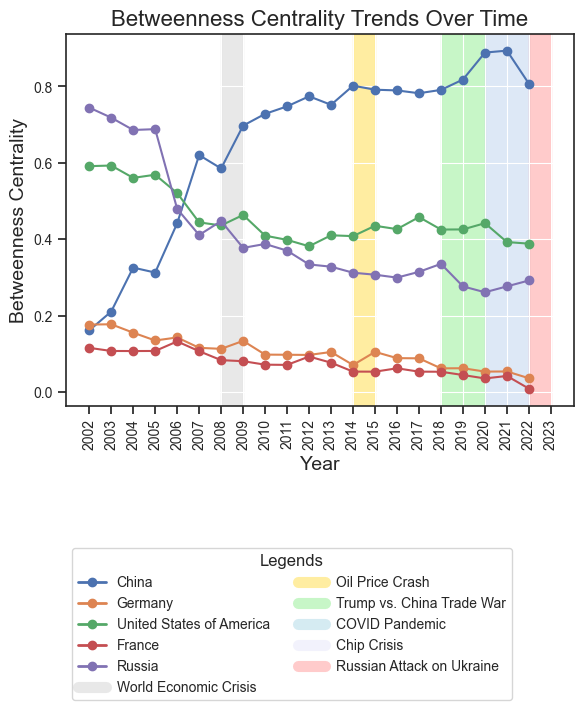

In [96]:
""" Total trade centrality """
func = nx.betweenness_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight")

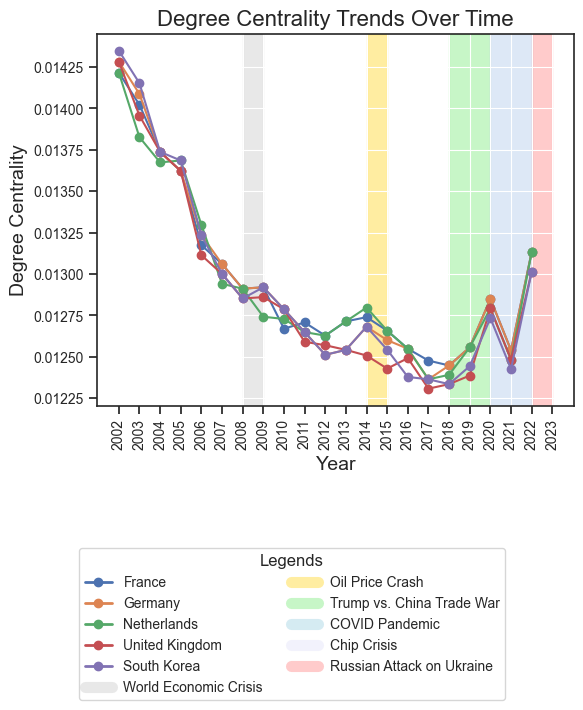

In [97]:
""" Total trade centrality """
func = nx.degree_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight")

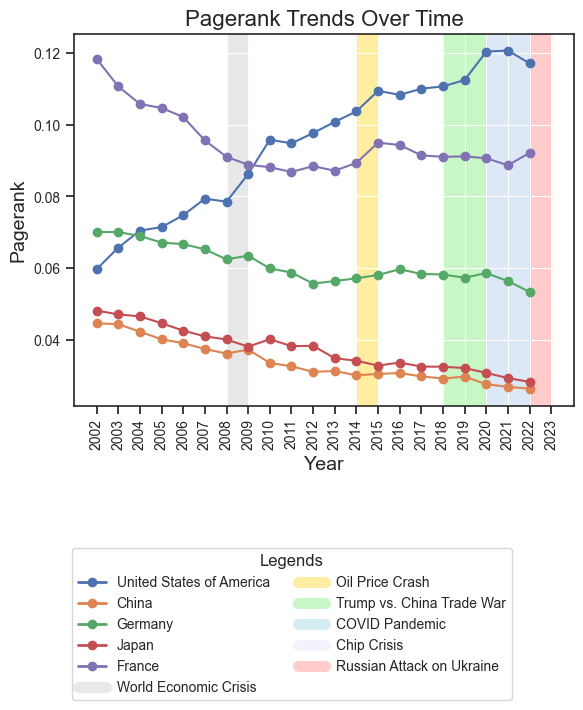

In [98]:
""" Total trade centrality """
func = nx.pagerank
process_visualization(yearly_baseline_graph, func, top_n=5, weight="weight")

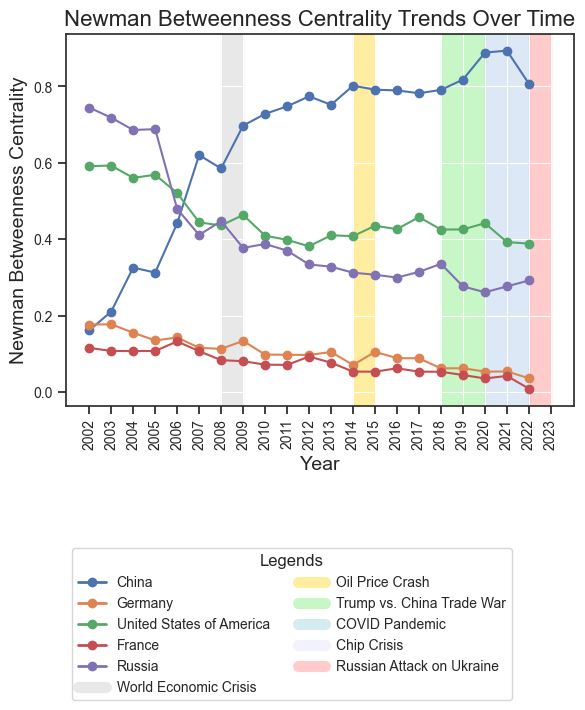

In [99]:
""" Total trade centrality """
func = nx.load_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, weight="inverse_weight")

### Crisis Classifier

In [100]:
import pandas as pd
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

crises = [
    (2008, 2009, "World Economic Crisis", '#d3d3d3'),
    (2014, 2015, "Oil Price Crash", '#ffa500'),
    (2018, 2020, "Trump vs. China Trade War", '#90ee90'),
    (2020, 2022, "COVID Pandemic", '#add8e6'),
    (2020, 2022, "Chip Crisis", '#e6e6fa'),
    (2022, 2023, "Russian Attack on Ukraine", '#ff9999'),
]

def label_crises(centrality_df):
    crisis_labels = []
    for _, row in centrality_df.iterrows():
        year = row['year']
        is_crisis = any(start <= year <= end for start, end, _, _ in crises)
        crisis_labels.append(int(is_crisis))
    centrality_df['is_crisis'] = crisis_labels
    return centrality_df

def extract_features(centrality_df, func_name):
    centrality_df['yearly_change'] = centrality_df.groupby('node')[func_name].diff()
    centrality_df['rolling_mean'] = centrality_df.groupby('node')[func_name].transform(lambda x: x.rolling(3, min_periods=1).mean())
    centrality_df['rolling_std'] = centrality_df.groupby('node')[func_name].transform(lambda x: x.rolling(3, min_periods=1).std())
    return centrality_df

def add_additional_features(graphs):
    feature_data = []
    for year, graph in graphs.items():
        node_features = {}
        betweenness_values = nx.betweenness_centrality(graph, weight='inverse_weight')
        for node, value in betweenness_values.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['betweenness_centrality'] = value
        closeness_values = nx.closeness_centrality(graph, distance='inverse_weight')
        for node, value in closeness_values.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['closeness_centrality'] = value
        degree_values = nx.degree_centrality(graph)
        for node, value in degree_values.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['degree_centrality'] = value
        pagerank_values = nx.pagerank(graph, weight='weight')
        for node, value in pagerank_values.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['pagerank'] = value
        clustering_values = nx.clustering(graph, weight='inverse_weight')
        for node, value in clustering_values.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['clustering'] = value
        avg_neighbor_degree = nx.average_neighbor_degree(graph, weight='inverse_weight')
        for node, value in avg_neighbor_degree.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['avg_neighbor_degree'] = value
        degree_values = dict(graph.degree(weight='inverse_weight'))
        for node, value in degree_values.items():
            if node not in node_features:
                node_features[node] = {'year': year, 'node': node}
            node_features[node]['weighted_degree'] = value
        feature_data.extend(node_features.values())
    return pd.DataFrame(feature_data)

def train_and_tune_model(X, y):
    X = X.fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    }
    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return best_model

def process_and_predict(yearly_graphs):
    centrality_df = add_additional_features(yearly_graphs)
    centrality_df = label_crises(centrality_df)
    for func_name in ['betweenness_centrality', 'closeness_centrality', 'degree_centrality', 'pagerank',
                       'clustering', 'avg_neighbor_degree', 'weighted_degree']:
        centrality_df = extract_features(centrality_df, func_name)
    train_data, test_data = train_test_split(centrality_df, test_size=0.2, random_state=42)
    features = [col for col in centrality_df.columns if col not in ['node', 'year', 'is_crisis']]
    X_train = train_data[features]
    y_train = train_data['is_crisis']
    X_test = test_data[features]
    y_test = test_data['is_crisis']
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    model = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=30)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classification Report for Test Data:")
    print(classification_report(y_test, y_pred))
    return model

best_model = process_and_predict(yearly_graphs)


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       552
           1       0.76      0.72      0.74       375

    accuracy                           0.80       927
   macro avg       0.79      0.78      0.79       927
weighted avg       0.80      0.80      0.80       927

